### Importing and Reading HI-Small_Trans.csv

In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv('HI-Small_Trans.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [4]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [5]:
df['Payment Currency'].value_counts()

US Dollar            1895172
Euro                 1168297
Swiss Franc           234860
Yuan                  213752
Shekel                192184
Rupee                 190202
UK Pound              180738
Yen                   155209
Ruble                 155178
Bitcoin               146066
Canadian Dollar       140042
Australian Dollar     136769
Mexican Peso          110159
Saudi Riyal            89014
Brazil Real            70703
Name: Payment Currency, dtype: int64

In [6]:
df['Is Laundering'].value_counts(normalize=True)


0    0.998981
1    0.001019
Name: Is Laundering, dtype: float64

### Feature Transformation

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
currency_conversion_rates = {
    'US Dollar': 1.0,
    'Euro': 1.03, 
    'Swiss Franc': 1.09, 
    'Yuan': 0.14, 
    'Shekel': 0.28,
    'Rupee': 0.012, 
    'UK Pound': 1.24, 
    'Yen': 0.0066, 
    'Ruble': 0.01, 
    'Bitcoin': 95781.21,
    'Canadian Dollar': 0.7, 
    'Australian Dollar': 0.63, 
    'Mexican Peso': 0.049, 
    'Saudi Riyal': 0.27, 
    'Brazil Real': 0.17
}

df['Amount Paid (USD)'] = df.apply(lambda row: row['Amount Paid'] * currency_conversion_rates.get(row['Payment Currency'], 1), axis=1)
df['Amount Received (USD)'] = df.apply(lambda row: row['Amount Received'] * currency_conversion_rates.get(row['Receiving Currency'], 1), axis=1)

In [9]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['year'] = df['Timestamp'].dt.year  
df['month'] = df['Timestamp'].dt.month  
df['day'] = df['Timestamp'].dt.day  
df['hour'] = df['Timestamp'].dt.hour
df['second'] = df['Timestamp'].dt.second 

df.drop(columns=['Timestamp','Amount Paid','Amount Received','From Bank','Account', 'To Bank', 'Account.1'], inplace=True)

cat_col = ['Receiving Currency', 'Payment Currency', 'Payment Format']
for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])


In [10]:
df.head()

,Receiving Currency,Payment Currency,Payment Format,Is Laundering,Amount Paid (USD),Amount Received (USD),year,month,day,hour,second
0,12,12,5,0,3697.34,3697.34,2022,9,1,0,0
1,12,12,3,0,0.01,0.01,2022,9,1,0,0
2,12,12,5,0,14675.57,14675.57,2022,9,1,0,0
3,12,12,5,0,2806.97,2806.97,2022,9,1,0,0
4,12,12,5,0,36682.97,36682.97,2022,9,1,0,0


### Training a Baseline ML Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1014634
           1       0.68      0.14      0.23      1035

    accuracy                           1.00   1015669
   macro avg       0.84      0.57      0.62   1015669
weighted avg       1.00      1.00      1.00   1015669

AUC-ROC Score: 0.7534


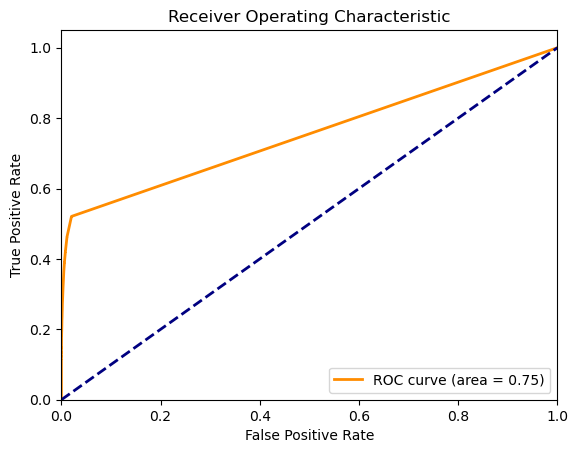

In [ ]:
X_columns = []

X =df.drop(columns='Is Laundering')
y = df['Is Laundering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

y_prob = clf.predict_proba(X_test)[:, 1]  
print(f'AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}')

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have your model predictions (y_pred_proba) and true labels (y_true) 

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob) 


# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_prob) 

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


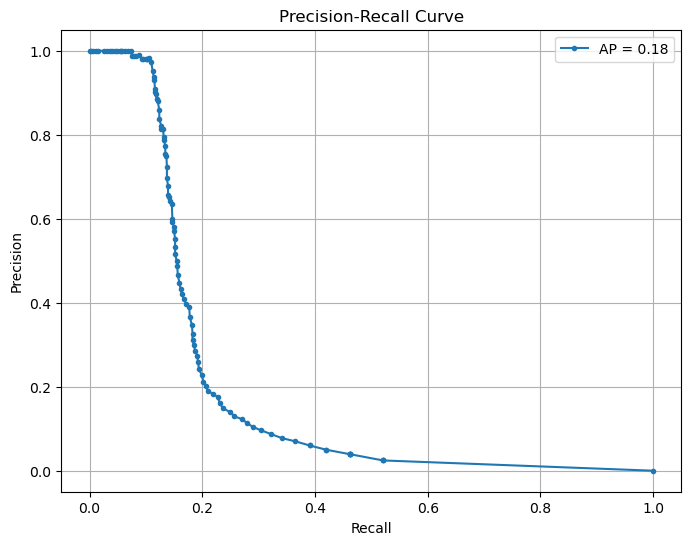

In [18]:
precision, recall, _ = precision_recall_curve(y_test,y_prob)
# Compute average precision score
avg_precision = average_precision_score(y_test, y_prob)

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()